# Desafio - Clusterização Hierarquica

🧪 Desafio de Machine Learning: Agrupamento Taxonômico de Espécies Fictícias

## Objetivo

Você é um pesquisador em biologia evolutiva e recebeu um conjunto de dados contendo características morfológicas, fisiológicas e comportamentais de 600 espécies *fictícias*.

Seu desafio é aplicar algoritmos de clusterização hierárquica para:

1. Agrupar as espécies com base nas características fornecidas.
2. Visualizar os agrupamentos utilizando dendrogramas.
3. Propor um corte nos agrupamentos e interpretar os "grupos taxonômicos" identificados.
4. Escrever uma análise dos resultados obtidos

## 🧬 Contexto

A classificação taxonômica é uma tarefa central na biologia, utilizada para compreender as relações entre organismos a partir de traços em comum. A clusterização hierárquica é um método interpretável que simula a formação de relações evolutivas entre espécies, semelhante a uma árvore filogenética.

Neste desafio, foram gerados no mínimo 10 agrupamentos distintos entre as espécies. Para fins didáticos, recomenda-se utilizar **10 como valor mínimo para o número de clusters** durante a análise.

Ressaltamos que os dados são **sintéticos** e não representam comportamentos ou informações de espécies reais.

## 📦 Dataset

O dataset contém **600 registros**, cada um representando uma espécie fictícia. Os atributos foram gerados de forma simulada, mas baseados em princípios inspirados na biologia real.

📌 Atributos numéricos e booleanos

| Nome               | Tipo   | Descrição                                                        |
|--------------------|--------|------------------------------------------------------------------|
| species_id         | string | Identificador único da espécie (ex: SP001)                       |
| body_mass_kg       | float  | Massa corporal média da espécie (em kg)                          |
| num_legs           | int    | Número de membros locomotores (ex: 0, 2, 4, 6)                   |
| has_wings          | bool   | Possui asas? (1 = sim, 0 = não)                                  |
| tail_length_cm     | float  | Comprimento médio da cauda (em centímetros)                      |
| eye_count          | int    | Quantidade de olhos (ex: 0, 2, 4)                                |
| nocturnal          | bool   | Ativo durante a noite? (1 = sim, 0 = não)                        |
| avg_lifespan_years | float  | Expectativa de vida média da espécie (em anos)                   |
| has_venom          | bool   | Espécie possui veneno ou toxina? (1 = sim, 0 = não)              |

📌 Atributos categóricos

| Nome            | Tipo   | Descrição                                                        |
|-----------------|--------|------------------------------------------------------------------|
| diet_type       | string | Tipo de dieta da espécie: herbivore, carnivore, omnivore         |
| skin_type       | string | Tipo de cobertura corporal: fur, scales, feathers, skin          |
| social_behavior | string | Comportamento social: solitary, pair-living, group-living        |

### Bibliotecas

In [ ]:
# pipenv install pandas seaborn scikit-learn matplotlib scipy ipywidgets ipykernel optuna streamlit plotly nbformat

# Importação das Bibliotecas
# EDA e visualização de dados
import pandas as pd 
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
import nbformat

# ML
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

# Otimização 
import optuna

### Carregar e avaliar os dados

In [2]:
# Dataframe
df_species = pd.read_csv('./datasets/species_dataset.csv')

In [3]:
# Analisar estrutura
df_species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   species_id          600 non-null    object 
 1   body_mass_kg        600 non-null    float64
 2   num_legs            600 non-null    int64  
 3   has_wings           600 non-null    int64  
 4   tail_length_cm      600 non-null    float64
 5   diet_type           600 non-null    object 
 6   eye_count           600 non-null    int64  
 7   skin_type           600 non-null    object 
 8   nocturnal           600 non-null    int64  
 9   avg_lifespan_years  600 non-null    float64
 10  has_venom           600 non-null    int64  
 11  social_behavior     600 non-null    object 
dtypes: float64(3), int64(5), object(4)
memory usage: 56.4+ KB


In [4]:
# Remover variável species_id
df_species_eda = df_species.drop(columns=['species_id'])

In [5]:
# Visualizar dados DataFrame
df_species_eda.head(10)

,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior
0,59.934283,6,1,27.622702,carnivore,2,fur,0,118.957538,0,pair-living
1,47.234714,6,1,25.521165,carnivore,4,fur,0,121.226422,0,solitary
2,62.953771,8,1,50.794426,carnivore,2,fur,0,119.454890,0,pair-living
3,80.460597,2,1,46.476993,carnivore,4,fur,1,121.522981,0,solitary
4,45.316933,4,0,40.161889,herbivore,2,scales,0,120.060929,0,group-living
5,45.317261,4,0,41.685437,omnivore,4,feathers,0,118.593000,1,group-living
6,81.584256,4,0,47.104705,carnivore,4,fur,1,119.828973,0,pair-living
7,65.348695,6,1,43.354369,carnivore,2,fur,1,118.937223,0,pair-living
8,40.610512,6,0,31.594468,omnivore,2,skin,0,120.589349,0,solitary
9,60.851201,2,1,54.130002,herbivore,2,scales,1,119.738637,0,pair-living


In [6]:
# Visualizar últimos registros
df_species_eda.tail(10)

,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior
590,51.431325,0,0,28.470813,carnivore,2,feathers,0,118.994146,0,solitary
591,40.446851,0,0,57.031126,herbivore,2,skin,1,118.290690,0,pair-living
592,59.579597,6,1,36.453271,herbivore,2,skin,0,120.651345,0,group-living
593,56.673242,2,1,48.350371,herbivore,2,feathers,0,118.680936,0,pair-living
594,70.750799,6,0,45.079643,omnivore,2,feathers,0,120.983923,0,pair-living
595,39.799672,4,0,55.037095,herbivore,2,scales,0,120.394072,0,group-living
596,44.602501,6,0,66.874888,herbivore,2,fur,1,120.294341,0,solitary
597,30.424726,0,1,32.096355,herbivore,2,fur,0,121.665309,1,pair-living
598,41.114135,0,0,38.510861,omnivore,2,skin,0,118.714197,0,group-living
599,57.546010,8,0,46.890925,carnivore,4,feathers,0,120.873772,0,pair-living


### EDA

In [7]:
# Estatísticas das variáveis 
df_species_eda.describe()

,body_mass_kg,num_legs,has_wings,tail_length_cm,eye_count,nocturnal,avg_lifespan_years,has_venom
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,49.784101,3.950000,0.285000,45.052394,2.203333,0.380000,120.024664,0.150000
std,19.297540,2.833882,0.451791,9.930405,1.074203,0.485791,0.976676,0.357369
min,5.000000,0.000000,0.000000,16.287173,0.000000,0.000000,117.364032,0.000000
25%,36.107729,2.000000,0.000000,38.446490,2.000000,0.000000,119.366525,0.000000
50%,50.154768,4.000000,0.000000,45.266501,2.000000,0.000000,120.008112,0.000000
75%,62.463348,6.000000,1.000000,51.858016,2.000000,1.000000,120.684532,0.000000
max,127.054630,8.000000,1.000000,72.308672,4.000000,1.000000,123.657702,1.000000


#### Análise univariada

In [ ]:
# Distribuição da variável 'diet_type' em %
percentual_diet_type= df_species_eda.value_counts('diet_type') / len(df_species_eda) * 100
px.bar(percentual_diet_type, color=percentual_diet_type.index)

In [ ]:
# Distribuição da variável 'social_behavior' em %
percentual_social_behavior = df_species_eda.value_counts('social_behavior') / len(df_species_eda) * 100
px.bar(percentual_social_behavior, color=percentual_social_behavior.index)

In [ ]:
# Distribuição da variável 'skin_type' em %
percentual_skin_type= df_species_eda.value_counts('skin_type') / len(df_species_eda) * 100
px.bar(percentual_skin_type, color=percentual_skin_type.index)

In [22]:
# Distribuição da variável 'num_legs' em %
percentual_skin_type= df_species_eda.value_counts('num_legs') / len(df_species_eda) * 100
px.bar(percentual_skin_type, color=percentual_skin_type.index)

In [23]:
# Distribuição da variável 'has_wings' em %
percentual_skin_type= df_species_eda.value_counts('has_wings') / len(df_species_eda) * 100
px.bar(percentual_skin_type, color=percentual_skin_type.index)

In [26]:
# Distribuição da variável 'eye_count' em %
percentual_skin_type= df_species_eda.value_counts('eye_count') / len(df_species_eda) * 100
px.bar(percentual_skin_type, color=percentual_skin_type.index)

In [28]:
# Distribuição da variável 'nocturnal' em %
percentual_skin_type= df_species_eda.value_counts('nocturnal') / len(df_species_eda) * 100
px.bar(percentual_skin_type, color=percentual_skin_type.index)

In [31]:
# Distribuição da variável 'has_venom' em %
percentual_skin_type= df_species_eda.value_counts('has_venom') / len(df_species_eda) * 100
px.bar(percentual_skin_type, color=percentual_skin_type.index)

<Axes: xlabel='tail_length_cm', ylabel='Count'>

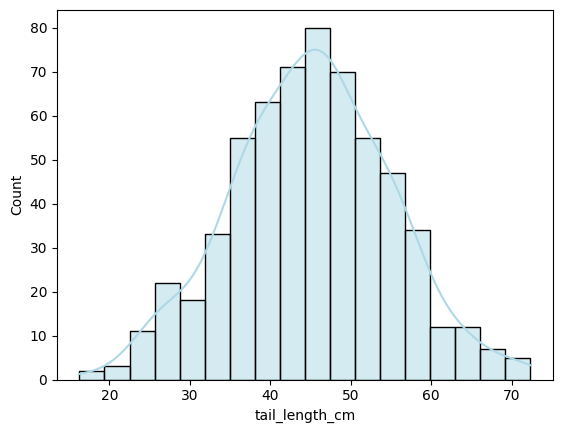

In [25]:
# Distrubuição da variável 'tail_length_cm' em quantidade
sns.histplot(df_species_eda['tail_length_cm'], kde=True, color='lightblue')

<Axes: xlabel='body_mass_kg', ylabel='Count'>

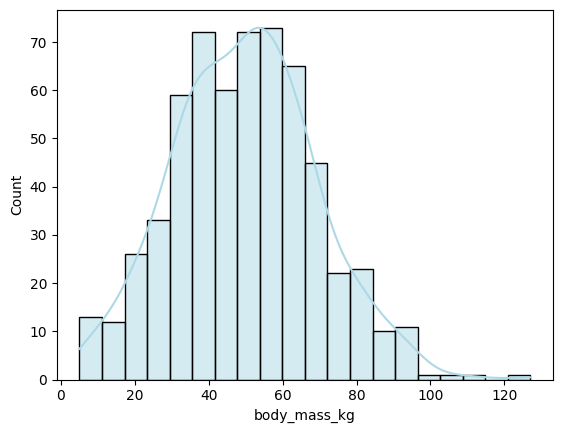

In [ ]:
# Distrubuição da variável 'body_mass_kg' em quantidade
sns.histplot(df_species_eda['body_mass_kg'], kde=True, color='lightblue')

<Axes: xlabel='diet_type', ylabel='Count'>

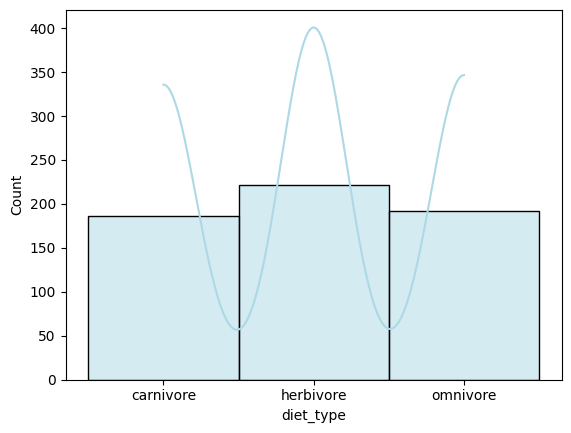

In [ ]:
# Distrubuição da variável 'diet_type' em quantidade
sns.histplot(df_species_eda['diet_type'], kde=True, color='lightblue')

<Axes: xlabel='skin_type', ylabel='Count'>

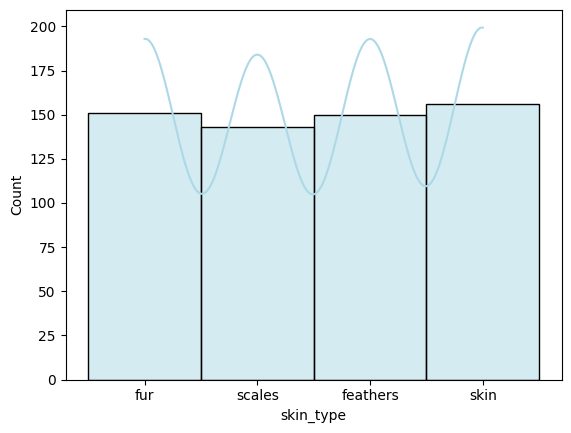

In [13]:
# Distrubuição da variável 'skin_type' em quantidade
sns.histplot(df_species_eda['skin_type'], kde=True, color='lightblue')

<Axes: xlabel='avg_lifespan_years', ylabel='Count'>

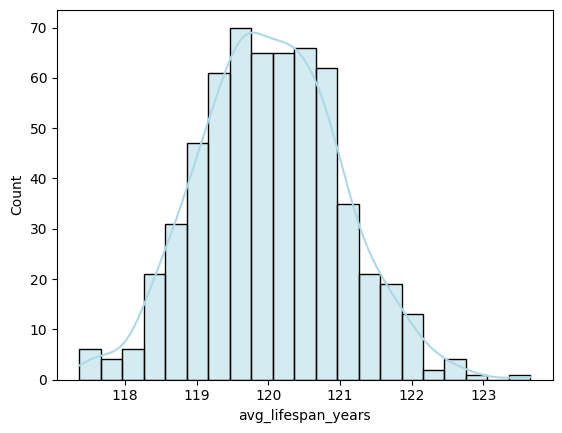

In [ ]:
# Distrubuição da variável 'avg_lifespan_years' em quantidade
sns.histplot(df_species_eda['avg_lifespan_years'], kde=True, color='lightblue')

#### Análise bivariada

In [ ]:
# Plot de distribuição (Boxplot) por 'nocturnal' e 'body_mass_kg'
px.box(df_species_eda, x='nocturnal', y='body_mass_kg', color='nocturnal')

In [21]:
# Plot de distribuição (Boxplot) por 'skin_type' e 'body_mass_kg'
px.box(df_species_eda, x='skin_type', y='body_mass_kg', color='skin_type')

In [ ]:
# Scatterplot de 'skin_type' e 'body_mass_kg' 
px.scatter(df_species_eda, x='skin_type', y='body_mass_kg', color='skin_type')

### Conclusão do EDA
- A análise exploratória dos dados (EDA) revelou uma grande diversidade morfológica, fisiológica e comportamental entre as espécies fictícias. As variáveis categóricas, como tipo de dieta, tipo de pele e comportamento social, apresentaram distribuição equilibrada entre suas categorias, indicando que o dataset foi construído para representar diferentes grupos taxonômicos. As variáveis numéricas, como massa corporal, comprimento da cauda e expectativa de vida, mostraram variações significativas, sugerindo que há espécies com características bem distintas. A análise bivariada evidenciou relações interessantes, como a influência do tipo de pele ou do comportamento noturno na massa corporal. Esses padrões reforçam o potencial do dataset para a aplicação de técnicas de clusterização e identificação de agrupamentos naturais entre as espécies.

---

### Teinar modelos clustering hierárquico

In [35]:
# Selecionar as colunas para clusterização
X = df_species.copy()

# Remover colunas desnecessárias para treino e clustering
X.drop(columns=['species_id'], axis=1, inplace=True)

In [36]:
# Validar X criado
X

,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior
0,59.934283,6,1,27.622702,carnivore,2,fur,0,118.957538,0,pair-living
1,47.234714,6,1,25.521165,carnivore,4,fur,0,121.226422,0,solitary
2,62.953771,8,1,50.794426,carnivore,2,fur,0,119.454890,0,pair-living
3,80.460597,2,1,46.476993,carnivore,4,fur,1,121.522981,0,solitary
4,45.316933,4,0,40.161889,herbivore,2,scales,0,120.060929,0,group-living
...,...,...,...,...,...,...,...,...,...,...,...
595,39.799672,4,0,55.037095,herbivore,2,scales,0,120.394072,0,group-living
596,44.602501,6,0,66.874888,herbivore,2,fur,1,120.294341,0,solitary
597,30.424726,0,1,32.096355,herbivore,2,fur,0,121.665309,1,pair-living
598,41.114135,0,0,38.510861,omnivore,2,skin,0,118.714197,0,group-living


In [37]:
# Separando variáveis numéricas e categoricas
numeric_features = ['body_mass_kg', 'num_legs', 'has_wings', 'tail_length_cm', 'eye_count', 'nocturnal', 'avg_lifespan_years', 'has_venom']
categorical_features = ['diet_type', 'skin_type', 'social_behavior']

In [38]:
# Aplicar transformações por tipo
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

In [39]:
# Criar preprocessador de transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [40]:
# Transformar os dados
X_transformed = preprocessor.fit_transform(X)

In [41]:
# Verificar X_transformed
X_transformed

array([[ 0.5264221 ,  0.72399302,  1.58391033, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13221963,  0.72399302,  1.58391033, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.68302273,  1.43032767,  1.58391033, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-1.00404132, -1.39501093,  1.58391033, ...,  0.        ,
         1.        ,  0.        ],
       [-0.44965315, -1.39501093, -0.63134887, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.40255834,  1.43032767, -0.63134887, ...,  0.        ,
         1.        ,  0.        ]])

In [45]:
# Função para otimização do modelo - AGLOMERATIVO

def hierachical_aglorerative_objective(trial):
    # Definindos os hiperparâmetros a serem ajustados
    n_clusters = trial.suggest_int('n_clusters', 10, 150)

    # Linkage = Critério de distância entre dois conjuntos para formar os clusters
    # Ward = Variância
    # Average = Média
    # Complete = Máxima
    # Single = Miníma
    linkage = trial.suggest_categorical('linkage', ['ward', 'average', 'complete', 'single'])

    # Instanciar o modelo
    hierachica_model = AgglomerativeClustering(linkage=linkage, n_clusters=n_clusters)

    # Treinar o modelo e já executar a clusterização 
    y = hierachica_model.fit_predict(X_transformed)

    # Calcular o Silhoutte Score - Varia de -1 (ruim) a 1 (bom). Quanto maior, melhor a separação entre os clusters.
    silhouette_avg = silhouette_score(X_transformed, y)

    return silhouette_avg

In [46]:
# Criar estudo no Optuna (Aglomerative)
search_space_ag = {'n_clusters': range(10, 151), 'linkage': ['ward', 'average', 'complete', 'single']}
sampler_ag = optuna.samplers.GridSampler(search_space=search_space_ag)
estudo_ag = optuna.create_study(direction='maximize', sampler=sampler_ag)

[I 2025-07-23 23:43:03,055] A new study created in memory with name: no-name-8fdc6c22-bbba-47d7-ab57-e4a9b53212f7


In [47]:
# Executar estudo do Optuna para Aglomerative (Aglomerative)
estudo_ag.optimize(hierachical_aglorerative_objective, n_trials=600)

[I 2025-07-23 23:43:04,907] Trial 0 finished with value: 0.08920742549638573 and parameters: {'n_clusters': 108, 'linkage': 'average'}. Best is trial 0 with value: 0.08920742549638573.
[I 2025-07-23 23:43:04,926] Trial 1 finished with value: 0.06952264766223992 and parameters: {'n_clusters': 44, 'linkage': 'complete'}. Best is trial 0 with value: 0.08920742549638573.
[I 2025-07-23 23:43:04,951] Trial 2 finished with value: 0.07090101644156098 and parameters: {'n_clusters': 57, 'linkage': 'average'}. Best is trial 0 with value: 0.08920742549638573.
[I 2025-07-23 23:43:04,973] Trial 3 finished with value: 0.06751505762324567 and parameters: {'n_clusters': 46, 'linkage': 'complete'}. Best is trial 0 with value: 0.08920742549638573.
[I 2025-07-23 23:43:05,000] Trial 4 finished with value: 0.11399187022420045 and parameters: {'n_clusters': 140, 'linkage': 'complete'}. Best is trial 4 with value: 0.11399187022420045.
[I 2025-07-23 23:43:05,024] Trial 5 finished with value: 0.0990955747361001

In [48]:
# Mostrar melhor configuração do Optuna (Aglomerative)
best_params_ag = estudo_ag.best_params

print(f'Clusters = {best_params_ag["n_clusters"]}')
print(f'Linkage = {best_params_ag["linkage"]}')

Clusters = 150
Linkage = ward


In [49]:
# Função para otimização do modelo - DIVISIVO

def hierachical_divisive_objective(trial):
    # Definindos os hiperparâmetros a serem ajustados
    n_clusters = trial.suggest_int('n_clusters', 10, 150)

    # Instanciar o modelo
    hierachica_model = BisectingKMeans(n_clusters=n_clusters)

    # Treinar o modelo e já executar a clusterização 
    y = hierachica_model.fit_predict(X_transformed)

    # Calcular o Silhoutte Score
    silhouette_avg = silhouette_score(X_transformed, y)

    return silhouette_avg

In [50]:
# Criar estudo no Optuna (Divisive)
search_space_di = {'n_clusters': range(10, 151)}
sampler_di = optuna.samplers.GridSampler(search_space=search_space_di)
estudo_di = optuna.create_study(direction='maximize', sampler=sampler_di)

[I 2025-07-23 23:46:15,265] A new study created in memory with name: no-name-68605030-4959-43f4-a5e0-6429cfa3c5d3


In [51]:
# Executar estudo do Optuna para Divisive (Divisive)
estudo_di.optimize(hierachical_divisive_objective, n_trials=200)

[I 2025-07-23 23:46:26,050] Trial 0 finished with value: 0.053536286732362395 and parameters: {'n_clusters': 55}. Best is trial 0 with value: 0.053536286732362395.
[I 2025-07-23 23:46:26,340] Trial 1 finished with value: 0.043254449832710866 and parameters: {'n_clusters': 70}. Best is trial 0 with value: 0.053536286732362395.
[I 2025-07-23 23:46:26,437] Trial 2 finished with value: 0.06701697658197678 and parameters: {'n_clusters': 17}. Best is trial 2 with value: 0.06701697658197678.
[I 2025-07-23 23:46:26,680] Trial 3 finished with value: 0.05283925137764129 and parameters: {'n_clusters': 61}. Best is trial 2 with value: 0.06701697658197678.
[I 2025-07-23 23:46:26,973] Trial 4 finished with value: 0.042114933325166394 and parameters: {'n_clusters': 76}. Best is trial 2 with value: 0.06701697658197678.
[I 2025-07-23 23:46:27,134] Trial 5 finished with value: 0.06069698716640187 and parameters: {'n_clusters': 37}. Best is trial 2 with value: 0.06701697658197678.
[I 2025-07-23 23:46:27,

In [52]:
# Mostrar melhor configuração do Optuna (Divisive)
best_params_di = estudo_di.best_params

print(f'Clusters = {best_params_di["n_clusters"]}')

Clusters = 12


In [53]:
# Criar modelo com melhor configuração (Aglomerative)

best_model = AgglomerativeClustering(
    n_clusters=best_params_ag['n_clusters'],
    linkage=best_params_ag['linkage']
)

In [55]:
# Treinar melhor modelo
best_model.fit(X_transformed)

AgglomerativeClustering(n_clusters=150)

In [56]:
# Verificar Silhoutte Score
best_score = silhouette_score(X_transformed, best_model.labels_)
best_score

np.float64(0.13129813063305099)

In [57]:
# Criar coluna com cluster escolhido no Dataframe original 
df_species['cluster'] = best_model.labels_

In [58]:
# Checar estrutura com a coluna 'cluster'
df_species.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   species_id          600 non-null    object 
 1   body_mass_kg        600 non-null    float64
 2   num_legs            600 non-null    int64  
 3   has_wings           600 non-null    int64  
 4   tail_length_cm      600 non-null    float64
 5   diet_type           600 non-null    object 
 6   eye_count           600 non-null    int64  
 7   skin_type           600 non-null    object 
 8   nocturnal           600 non-null    int64  
 9   avg_lifespan_years  600 non-null    float64
 10  has_venom           600 non-null    int64  
 11  social_behavior     600 non-null    object 
 12  cluster             600 non-null    int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 61.1+ KB


In [59]:
# Checar primeiros registros com a coluna 'cluster'
df_species.head(10)

,species_id,body_mass_kg,num_legs,has_wings,tail_length_cm,diet_type,eye_count,skin_type,nocturnal,avg_lifespan_years,has_venom,social_behavior,cluster
0,SP000,59.934283,6,1,27.622702,carnivore,2,fur,0,118.957538,0,pair-living,46
1,SP001,47.234714,6,1,25.521165,carnivore,4,fur,0,121.226422,0,solitary,30
2,SP002,62.953771,8,1,50.794426,carnivore,2,fur,0,119.454890,0,pair-living,47
3,SP003,80.460597,2,1,46.476993,carnivore,4,fur,1,121.522981,0,solitary,3
4,SP004,45.316933,4,0,40.161889,herbivore,2,scales,0,120.060929,0,group-living,122
5,SP005,45.317261,4,0,41.685437,omnivore,4,feathers,0,118.593000,1,group-living,56
6,SP006,81.584256,4,0,47.104705,carnivore,4,fur,1,119.828973,0,pair-living,34
7,SP007,65.348695,6,1,43.354369,carnivore,2,fur,1,118.937223,0,pair-living,111
8,SP008,40.610512,6,0,31.594468,omnivore,2,skin,0,120.589349,0,solitary,60
9,SP009,60.851201,2,1,54.130002,herbivore,2,scales,1,119.738637,0,pair-living,97


### Visualizar resultados

In [67]:
# Mostrar chart com trials do Optuna
fig = optuna.visualization.plot_optimization_history(estudo_ag)
fig.show()

In [66]:
# Mostrar chart com trials do Optuna
fig = optuna.visualization.plot_optimization_history(estudo_di)
fig.show()

In [61]:
# Treinar modelo com Scipy
modelo_de = linkage(X_transformed, method=best_params_ag['linkage'], optimal_ordering=True)

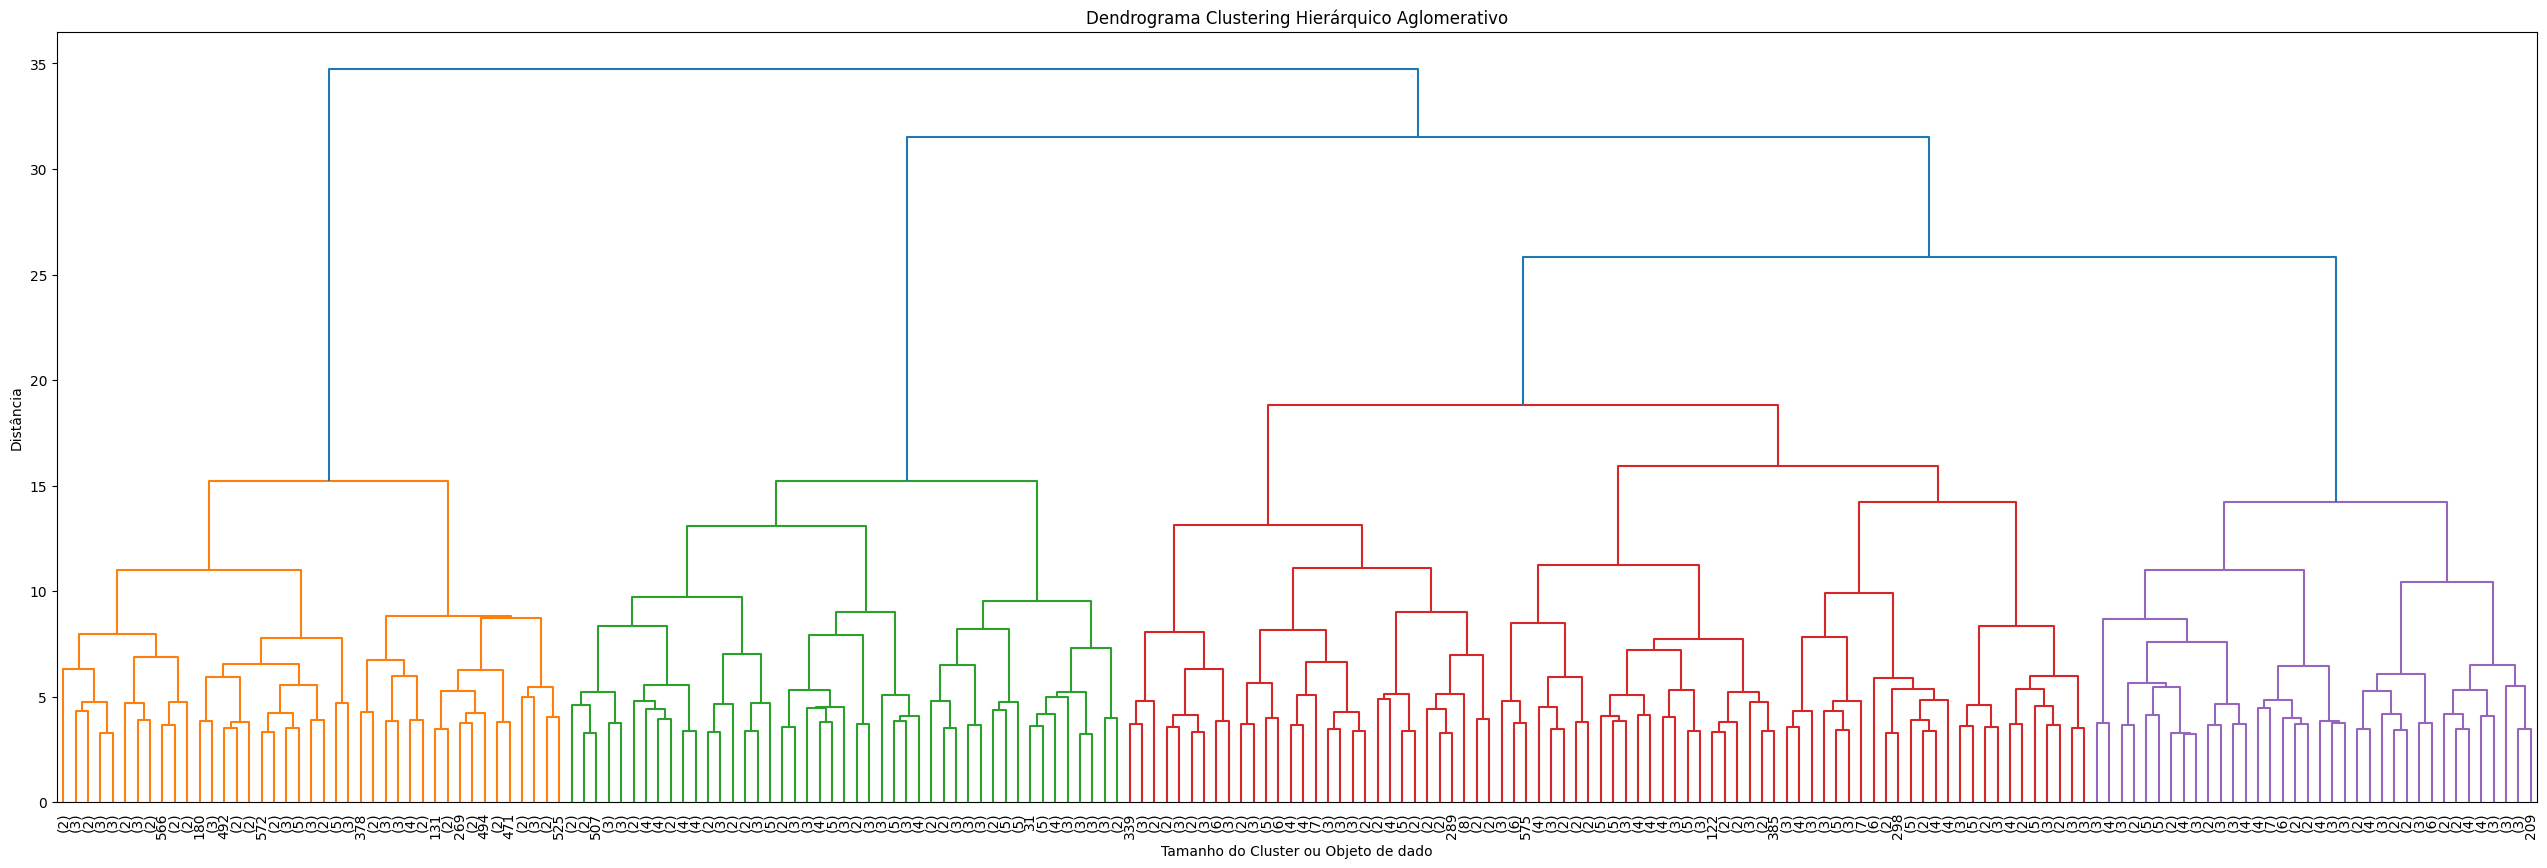

In [70]:
# Mostrar dendrograma
plt.figure(figsize=(32,10))
dendrogram(modelo_de, truncate_mode='lastp', p=200, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrograma Clustering Hierárquico Aglomerativo')
plt.xlabel('Tamanho do Cluster ou Objeto de dado')
plt.ylabel('Distância')
plt.show()

In [71]:
# Cortar dendrograma
cluster_de_scipy = cut_tree(modelo_de, height=1)
len(np.unique(cluster_de_scipy))

585

In [ ]:
# Scatterplot de 'skin_type' e 'body_mass_kg' com o cluster 
px.scatter(df_species, x='skin_type', y='body_mass_kg', color='cluster')

In [74]:
# Scatterplot de 'diet_type' e 'body_mass_kg' com o cluster 
px.scatter(df_species, x='diet_type', y='body_mass_kg', color='cluster')

In [75]:
# Scatterplot de 'diet_type' e 'has_venom' com o cluster 
px.scatter(df_species, x='diet_type', y='has_venom', color='cluster')

In [76]:
# Scatterplot de 'num_legs' e 'has_venom' com o cluster 
px.scatter(df_species, x='num_legs', y='has_venom', color='cluster')

In [77]:
# Distribuicao da variavel cluster
qtde_cluster = df_species.value_counts('cluster')
px.bar(qtde_cluster, color=qtde_cluster.index)

### Conclusão geral

- O projeto demonstrou com sucesso a aplicação de algoritmos de clusterização hierárquica para agrupar espécies fictícias com base em múltiplas características. Utilizando técnicas de pré-processamento e otimização de hiperparâmetros, foi possível identificar agrupamentos taxonômicos consistentes e visualizá-los por meio de dendrogramas e gráficos interativos. O uso do Silhouette Score permitiu avaliar a qualidade dos clusters formados, garantindo uma boa separação entre os grupos. Os resultados obtidos mostram que a clusterização hierárquica é uma abordagem eficiente e interpretável para problemas de classificação taxonômica, mesmo em dados sintéticos. O projeto reforça a importância da análise exploratória e da escolha criteriosa de métodos para obter agrupamentos significativos e úteis para estudos evolutivos e biológicos.